In [1]:
import os
import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

%run Model.ipynb
%run DataLoader.ipynb

cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
images_dir = "/home/mj/HardDisk/Github/Image_Compressor/Dataset/Open_images_2019/train"
outputs_dir = "/home/mj/HardDisk/Github/Image_Compressor/Model"
batch_size = 1
threads = 1
lr = 2e-3
num_epochs = 100
patch_size = 128
jpeg_quality = 10
use_augmentation = True
use_fast_loader = False
### 欠初始一些參數


model = FastARCNN()

model = model.to(device)
print(model)
criterion = nn.MSELoss(reduction='sum')

# optimizer = optim.Adam([
#     {'params': model.base.parameters()},
#     {'params': model.last.parameters(), 'lr': lr * 0.1},
# ], lr=lr)

dataset = Dataset(images_dir, patch_size, jpeg_quality, use_augmentation, use_fast_loader)
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=threads,
                        pin_memory=True,
                        drop_last=True)

for i in range(5):
    lr = lr*0.7
    optimizer = optim.Adam([
        {'params': model.base.parameters()},
        {'params': model.last.parameters(), 'lr': lr * 0.1},
    ], lr=lr)
    
    
    for epoch in range(i*20 ,int(num_epochs/5 + i*20)):
        epoch_losses = AverageMeter()
        target_losses = AverageMeter()

        with tqdm(total=(len(dataset) - len(dataset) % batch_size)) as _tqdm:
            _tqdm.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))
            for data in dataloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                preds = model(inputs)

                loss = criterion(preds, labels)
                target = criterion(inputs, labels)

                epoch_losses.update(loss.item(), len(inputs))
                target_losses.update(target.item(), len(inputs))


                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _tqdm.set_postfix(loss='{:.6f}, target={:.6f}'.format(epoch_losses.avg, target_losses.avg))
                _tqdm.update(len(inputs))

        torch.save(model.state_dict(), os.path.join(outputs_dir, 'FastARCNN_epoch_{}.pth'.format(epoch)))

FastARCNN(
  (base): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): PReLU(num_parameters=1)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (12): PReLU(num_parameters=1)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): PReLU(num_parameters=1)
    (15): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (16): PReLU(num_parameters=1)
  )
  (last): ConvTranspose2d(16, 3, k

epoch: 1/100:   2%|▏         | 1600/99999 [34:03<34:54:17,  1.28s/it, loss=146822.778514, target=3524.897888] 


RuntimeError: CUDA out of memory. Tried to allocate 5.65 GiB (GPU 0; 7.92 GiB total capacity; 1.11 GiB already allocated; 5.66 GiB free; 63.69 MiB cached)

In [10]:
import matplotlib.pyplot as plt
import torchvision

In [136]:
class Dataset(object):
    def __init__(self, images_dir, patch_size, jpeg_quality, use_augmentation=False, use_fast_loader=False):
        self.image_files = sorted(glob.glob(images_dir + '/*'))
        self.patch_size = patch_size
        self.jpeg_quality = jpeg_quality
        self.use_augmentation = use_augmentation
        self.use_fast_loader = use_fast_loader

    def __getitem__(self, idx):
        if self.use_fast_loader:
            label = tf.read_file(self.image_files[idx])
            label = tf.image.decode_jpeg(label, channels=3)
            label = pil_image.fromarray(label.numpy())
        else:
            label = pil_image.open(self.image_files[idx]).convert('RGB')

        if self.use_augmentation:
            # randomly rescale image
            if random.random() <= 0.5:
                scale = random.choice([0.9, 0.8, 0.7, 0.6])
                label = label.resize((int(label.width * scale), int(label.height * scale)), resample=pil_image.BICUBIC)

            # randomly rotate image
            if random.random() <= 0.5:
                label = label.rotate(random.choice([90, 180, 270]), expand=True)
                

        # randomly crop patch from training set
#         crop_x = random.randint(0, label.width - self.patch_size)
#         crop_y = random.randint(0, label.height - self.patch_size)
#         label = label.crop((crop_x, crop_y, crop_x + self.patch_size, crop_y + self.patch_size))

        # additive jpeg noise
        buffer = io.BytesIO()
        label.save(buffer, format='jpeg', quality=self.jpeg_quality)
        input = pil_image.open(buffer)

        input = np.array(input).astype(np.float32)
        label = np.array(label).astype(np.float32)
        input = np.transpose(input, axes=[2, 0, 1])
        label = np.transpose(label, axes=[2, 0, 1])

        # normalization
        input /= 255.0
        label /= 255.0

        return input, label

    def __len__(self):
        return len(self.image_files)

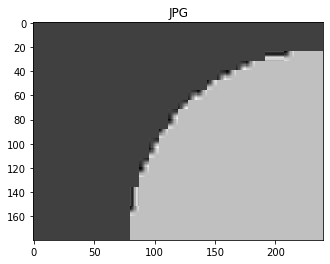

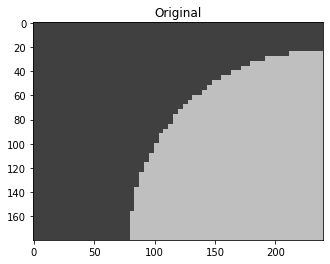

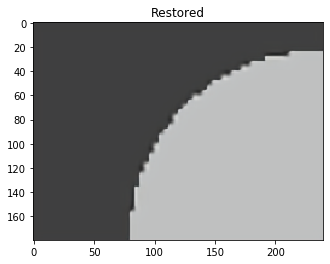

In [150]:



patch_size = 512

test_dir = "/home/mj/HardDisk/Github/Image_Compressor/Report/Test"
test_dataset = Dataset(test_dir, patch_size, 2, False, use_fast_loader)
test_dataloader = DataLoader(dataset=test_dataset,
                        batch_size=1,
                        shuffle=True,
                        num_workers=1,
                        pin_memory=True,
                        drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for data in test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    preds = model(inputs)
    
#     print((inputs*255).type(torch.cuda.ByteTensor))
#     print((labels*255).type(torch.cuda.ByteTensor))
#     print((preds*255).type(torch.cuda.ByteTensor))

# torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0)

    inputs = (inputs*255).cpu().type(torch.ByteTensor)
    labels = (labels*255).cpu().type(torch.ByteTensor)
    preds = (preds*255).cpu().type(torch.ByteTensor)
    
    plt.imshow(torchvision.utils.make_grid(inputs,nrow=1).permute(1, 2, 0))
    plt.title("JPG")
    plt.savefig("/home/mj/HardDisk/Github/Image_Compressor/Report/result/jpg_4.png")
    plt.show()
    
    plt.imshow(torchvision.utils.make_grid(labels,nrow=1).permute(1, 2, 0))
    plt.title("Original")
    plt.savefig("/home/mj/HardDisk/Github/Image_Compressor/Report/result/ori_4.png")
    plt.show()
    
    plt.imshow(torchvision.utils.make_grid(preds,nrow=1).permute(1, 2, 0))
    plt.title("Restored")
    plt.savefig("/home/mj/HardDisk/Github/Image_Compressor/Report/result/restored_4.png")
    plt.show()
    break